In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint as pp
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

In [5]:
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [6]:
from pycaret.classification import *

In [7]:
from helper_methods import make_dataframes_from_classification_report
from helper_methods import print_info_from_pycaret_setup
from helper_methods import find_dataframes_series_from_pycaret_setup, find_train_test_data_from_pycaret_setup

# OBJECTIVE

# preamble
### logical to control dataset sizes for modeling
##### `True` gives very small train and test set sizes for developing and debugging notebook
##### `False` splits entire dataset into train and test

In [8]:
#use_small_data_set = True
use_small_data_set = False

#num_tuning_cv_iterations = 3
#num_tuning_cv_iterations = 5
#num_tuning_cv_iterations = 10
num_tuning_cv_iterations = 15

optimize_metric = 'F1 Macro'
#optimize_metric = 'F1 Custom'

### pickle file name

In [9]:
#running_on_local_machine = True
running_on_local_machine = False

if running_on_local_machine:
    pickle_file_name = 'data/wrangled_data_update_soil.pkl'
    tuning_results_dir = 'tuning_results/'
else:
    pickle_file_name = '/storage/wrangled_data_update_soil.pkl'
    tuning_results_dir = 'tuning_results/'

# read wrangled data from pickle

In [10]:
df_data = pd.read_pickle(pickle_file_name)

In [11]:
df_data.shape
df_data.columns
df_data.head()

(581012, 71)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wild_area_rawah,wild_area_neota,wild_area_comanche_peak,wild_area_cache_la_poudre,soil_type_1,soil_type_2,soil_type_3,soil_type_4,soil_type_5,soil_type_6,soil_type_7,soil_type_8,soil_type_9,soil_type_10,soil_type_11,soil_type_12,soil_type_13,soil_type_14,soil_type_15,soil_type_16,soil_type_17,soil_type_18,soil_type_19,soil_type_20,soil_type_21,soil_type_22,soil_type_23,soil_type_24,soil_type_25,soil_type_26,soil_type_27,soil_type_28,soil_type_29,soil_type_30,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type,wilderness_index,wilderness_area,soil_index,climatic_zone,geologic_zone,both_zones,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,rawah,12,4,7,47,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,rawah,30,7,7,77,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,rawah,29,7,7,77,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [12]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']

soil_cluster_cols = ['climatic_zone', 'geologic_zone', 'both_zones']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nsoil_cluster_cols:')
pp(soil_cluster_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [13]:
len(df_data.columns)

71

In [14]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols
    + soil_type_cols + reverse_one_hot_cols + target_col + soil_cluster_cols)

71

# function to build feature columns list

In [15]:
def make_feature_columns_list(numerical_scaled, wild_area_one_hot, soil_type_one_hot, soil_type_cluster='none'):
    feature_cols_list = []
    
    if numerical_scaled:
        feature_cols_list += scaled_numerical_cols
    else:
        feature_cols_list += numerical_cols
    
    if wild_area_one_hot:
        feature_cols_list += wild_area_cols
    else:
        feature_cols_list.append(reverse_one_hot_cols[0])
    
    if soil_type_one_hot:
        feature_cols_list += soil_type_cols
    elif soil_type_cluster=='none':
        feature_cols_list.append(reverse_one_hot_cols[2])
    elif soil_type_cluster=='climatic':
        feature_cols_list.append(soil_cluster_cols[0])
    elif soil_type_cluster=='geologic':
        feature_cols_list.append(soil_cluster_cols[1])
    elif soil_type_cluster=='both':
        feature_cols_list.append(soil_cluster_cols[2])
    else:
        print('ERROR ERROR ERROR ERROR in selection of soil type columns')
    
    return feature_cols_list

In [16]:
temp_list = make_feature_columns_list(numerical_scaled=True, wild_area_one_hot=False,
                                      soil_type_one_hot=False, soil_type_cluster='both')
pp(temp_list)

['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wilderness_index',
 'both_zones']


# function to get target name from target integer value

In [17]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# select columns

In [18]:
feature_cols_all = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                                soil_type_one_hot=False, soil_type_cluster='none')
feature_cols_all += soil_cluster_cols
feature_cols_all

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'climatic_zone',
 'geologic_zone',
 'both_zones']

# train-test split

In [19]:
if use_small_data_set:
    train_sample_size = 10000
    test_sample_size  = 3000

    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [20]:
X_train.shape
X_test.shape

(406708, 15)

(174304, 15)

### make dataframe with test and train

In [21]:
df_data_to_use = (pd.concat([X_train, y_train], axis=1)).append(pd.concat([X_test, y_test], axis=1))
df_data_to_use.shape
df_data_to_use.head()

(581012, 16)

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,soil_index,climatic_zone,geologic_zone,both_zones,cover_type
511216,3153,67,16,256,21,1368,235,206,98,2372,2,39,8,7,87,1
234324,2738,186,17,30,5,1243,220,250,157,1950,2,13,4,7,47,1
446270,3238,13,4,467,203,2816,215,231,152,2942,2,31,7,7,77,1
50042,2759,331,6,124,2,2249,206,233,165,3955,0,12,4,7,47,2
549678,3414,234,21,60,0,2121,180,253,205,3431,1,32,7,7,77,1


### distribution of target values

In [22]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


In [23]:
cover_type_large_classes = list(df_target_dist['cover_type'][:2])
cover_type_small_classes = list(df_target_dist['cover_type'][-5:])
cover_type_large_classes
cover_type_small_classes

[2, 1]

[3, 7, 6, 5, 4]

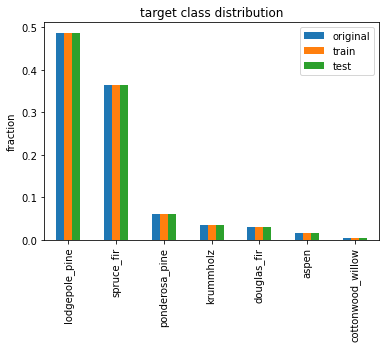

In [24]:
for_plot = ['target_name', 'original', 'train', 'test']
_ = df_target_dist[for_plot].set_index('target_name').plot.bar();
_ = plt.title('target class distribution');
_ = plt.xlabel('')
_ = plt.ylabel('fraction')

# column selection
### numeric; index wild; geologic soil

In [25]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='geologic')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'geologic_zone',
 'cover_type']

['wilderness_index', 'geologic_zone']

# `imblearn` preparation
### `pycaret` encodes target classes as `0 to 6` before using `imbalanced_learn`
### `pycaret` one-hot encodes `wilderness_index` before using `imbalanced_learn`   
### `pycaret` applies `imbalanced_learn` to training set (I believe)

In [26]:
# THIS CELL FOR GEOLOGIC ENCODING
features_cat_pycaret_pre_process = features_cat
features_cat_imblearn = [10, 11, 12, 13, 14, 15, 16, 17]
features_cat_pycaret_pre_process
features_cat_imblearn

['wilderness_index', 'geologic_zone']

[10, 11, 12, 13, 14, 15, 16, 17]

In [27]:
def create_dict_target_count(orig_counts, dict_factors, train_fraction):
    dict_target_count = {}
    list_classes_clean = []
    
    for target, factor in dict_factors.items():
        dict_target_count[target-1] = int(orig_counts.loc[target].values[0] * factor)
        
        if factor != 1:
            list_classes_clean.append(target-1)
            dict_target_count[target-1] = int(dict_target_count[target-1] * train_fraction)
    
    return dict_target_count, list_classes_clean

In [28]:
target_counts_to_use = df_data_to_use[target_col].value_counts().sort_index()
target_counts_to_use

cover_type
1             211840
2             283301
3              35754
4               2747
5               9493
6              17367
7              20510
dtype: int64

In [29]:
#target_factors = [1, 1, 3.04, 3.14, 3.06, 3.05, 3.02]
dict_factors = {1:1, 2:1, 3:3.04, 4:3.14, 5:3.06, 6:3.05, 7:3.02}
train_fraction = 0.7
dict_target_counts, list_classes_clean = create_dict_target_count(target_counts_to_use, dict_factors, train_fraction)
dict_target_counts
list_classes_clean

{0: 211840, 1: 283301, 2: 76084, 3: 6037, 4: 20333, 5: 37078, 6: 43358}

[2, 3, 4, 5, 6]

In [30]:
the_smote_nc = SMOTENC(categorical_features=features_cat_imblearn, random_state=59,
                       sampling_strategy=dict_target_counts)

the_enn = EditedNearestNeighbours(sampling_strategy=list_classes_clean,
                                  n_neighbors=3, kind_sel='mode')

the_smote = SMOTEENN(random_state=59, smote=the_smote_nc, enn=the_enn)

# `pycaret` prep
### `silent = True` to supress interactive confirmation of data types
### `n_jobs = -1` default; use all processors
### `n_jobs = 'None'` use single processor

In [31]:
#su_n_jobs = -1
su_n_jobs = 8

#su_log_profile = True
su_log_profile = False

su_silent = True
#su_silent = False

#su_log_exp = True
su_log_exp = False

su_use_gpu = False
#su_use_gpu = not running_on_local_machine
print('su_use_gpu = ', su_use_gpu)

su_name_exp = 'tune decision tree'

su_use_gpu =  False


### variables to hold modeling results

In [32]:
df_report_by_class = pd.DataFrame()
df_report_summary  = pd.DataFrame()

In [33]:
def grand_dataframe_creation(the_tuned_model, model_name,
                             the_df_data, train_indices, test_indices,
                             clear_data_frame=False):
    
    global df_report_by_class, df_report_summary
    
    if (clear_data_frame):
        df_report_by_class = pd.DataFrame()
        df_report_summary  = pd.DataFrame()
    
    # metrics by class
    pycaret_target_names = [1, 2, 3, 4, 5, 6, 7]
    
    if len(train_indices) == 0:
        data_name = 'all'
        
        # predict data
        prediction = predict_model(the_tuned_model, data = the_df_data)
        
        df_by_class_temp, df_summary_temp = \
        make_dataframes_from_classification_report(model_name, data_name, pycaret_target_names,
                                                   prediction['cover_type'], prediction['Label'])
        # add to master dataframes
        df_report_by_class  = df_report_by_class.append(df_by_class_temp, ignore_index=True)
        df_report_summary   = df_report_summary.append(df_summary_temp, ignore_index=True)
    
    else:  
        data_to_predict = {'train' : train_indices ,
                           'test'  : test_indices
                          }

        for data_name, data_indices in data_to_predict.items():
            # predict data
            prediction = predict_model(the_tuned_model, data = the_df_data.loc[data_indices])
            #print('\nprediction')
            #print(prediction.shape)
            #print(prediction.head())

            df_by_class_temp, df_summary_temp = \
            make_dataframes_from_classification_report(model_name, data_name, pycaret_target_names,
                                                       prediction['cover_type'], prediction['Label'])

            # add to master dataframes
            df_report_by_class  = df_report_by_class.append(df_by_class_temp, ignore_index=True)
            df_report_summary   = df_report_summary.append(df_summary_temp, ignore_index=True)   
    
    return


# `pycaret` metrics

In [34]:
pycaret_large_classes = list(np.array(cover_type_large_classes) - 1)
pycaret_small_classes = list(np.array(cover_type_small_classes) - 1)
pycaret_large_classes
pycaret_small_classes

[1, 0]

[2, 6, 5, 4, 3]

In [35]:
def custom_f1_metric(y_true, y_pred):
    pycaret_large_classes = list(np.array(cover_type_large_classes) - 1)
    pycaret_small_classes = list(np.array(cover_type_small_classes) - 1)
    
    fac_small = 3
    fac_large = 1
    
    f1_small = f1_score(y_true, y_pred, average='macro', labels=pycaret_small_classes)
    f1_large = f1_score(y_true, y_pred, average='macro', labels=pycaret_large_classes)
        
    return (fac_small * f1_small + fac_large * f1_large) / (fac_small + fac_large)

In [36]:
def specify_metrics():
    get_metrics(reset=True)

    delete_metrics = ['auc', 'recall', 'kappa', 'mcc']
    for item in delete_metrics:
        remove_metric(item)

    _ = add_metric('re_wgt', 'Recall Weighted', recall_score, average='weighted')

    _ = add_metric('pr_macro', 'Precision Macro', precision_score, average='macro')
    _ = add_metric('re_macro', 'Recall Macro', recall_score, average='macro')
    _ = add_metric('f1_macro', 'F1 Macro', f1_score, average='macro')
    _ = add_metric('f1_custom', 'F1 Custom', custom_f1_metric)

# `pycaret` `setup`

In [37]:
su_grand     = setup(data = df_su, target = target_col[0],
                     categorical_features = features_cat_pycaret_pre_process,
                     normalize = True, normalize_method = 'minmax',
                     fix_imbalance = True, fix_imbalance_method = the_smote,
                     train_size = 0.7, fold = 3, session_id = 59, use_gpu = su_use_gpu, n_jobs = su_n_jobs,
                     log_experiment = su_log_exp, experiment_name = su_name_exp, log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
dict_su_data = find_train_test_data_from_pycaret_setup(su_grand,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 1 type= <class 'pandas.core.series.Series'> (581012,)
item= 12 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (174304, 18)
item= 17 type= <class 'pandas.core.series.Series'> (406708,)
item= 31 type= <class 'pandas.core.frame.DataFrame'> (406708, 18)
item= 37 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 18)


{'X_train': 31, 'y_train': 17, 'X_test': 14, 'y_test': 12}

In [39]:
su_train_indices = su_grand[dict_su_data['X_train']].index
su_test_indices  = su_grand[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

In [40]:
df_su.loc[su_train_indices]

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,geologic_zone,cover_type
386294,2954,19,17,552,159,3094,206,203,130,886,2,7,2
93226,2926,295,11,306,17,5651,190,237,187,3361,0,2,2
1249,3178,263,9,272,58,5807,197,245,187,2941,0,2,2
298742,2971,132,15,90,9,888,242,232,115,175,2,7,2
469966,3294,1,12,446,98,2758,203,217,152,2325,2,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528447,3070,250,19,335,44,3443,177,250,209,1549,2,7,1
23996,2860,45,7,402,88,3548,222,224,137,6032,0,7,1
127908,3011,90,7,150,14,4279,231,229,130,684,0,7,2
543892,3216,1,17,366,69,4152,194,206,148,930,2,7,1


In [41]:
columns_X_train = su_grand[dict_su_data['X_train']].columns
len(columns_X_train)
columns_X_train
columns_X_train[features_cat_imblearn]

18

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wilderness_index_0', 'wilderness_index_1',
       'wilderness_index_2', 'wilderness_index_3', 'geologic_zone_1',
       'geologic_zone_2', 'geologic_zone_5', 'geologic_zone_7'],
      dtype='object')

Index(['wilderness_index_0', 'wilderness_index_1', 'wilderness_index_2',
       'wilderness_index_3', 'geologic_zone_1', 'geologic_zone_2',
       'geologic_zone_5', 'geologic_zone_7'],
      dtype='object')

# `pycaret` `tune_model`
https://pycaret.org/tune-model/   
https://pycaret.readthedocs.io/en/latest/api/classification.html

# CatBoost
https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html   
https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list
### `compare_models`

In [42]:
models_to_run = ['catboost']
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f6b70782940>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f6b7078c790>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f6b7078c670>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f6b7078c790>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f6b7078c160>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_custom,F1 Custom,F1 Custom,<function custom_f1_metric at 0x7f6b56cd6940>,make_scorer(custom_f1_metric),pred,{},True,True,True


In [43]:
#model_cb = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))
model_cb = create_model(estimator=models_to_run[0], cross_validation=False)

,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,F1 Custom
0,0.8737,0.8736,0.8734,0.8737,0.8514,0.8483,0.8492,0.8479


In [44]:
model_cb

### `tune_model` customize grid

In [45]:
tune_grid_cb = {'n_estimators': [50, 100, 150, 200, 300],
                'random_strength': [0.0, 0.2, 0.4, 0.6, 0.8],
                'l2_leaf_reg': [0.1, 1, 10, 100],
                'depth': [2, 4, 6, 8, 10]
               }

In [46]:
custom_tuned_cb, custom_tuner_models_cb = tune_model(model_cb, fold = 3, n_iter = num_tuning_cv_iterations,
                                             optimize = optimize_metric,
                                             custom_grid = tune_grid_cb, return_tuner = True)

,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,F1 Custom
0,0.7959,0.7957,0.7937,0.7959,0.7705,0.6889,0.7146,0.7101
1,0.7964,0.7962,0.7941,0.7964,0.7671,0.6879,0.7126,0.7081
2,0.7950,0.7947,0.7926,0.7950,0.7730,0.6913,0.7167,0.7124
Mean,0.7958,0.7955,0.7935,0.7958,0.7702,0.6894,0.7146,0.7102
SD,0.0006,0.0006,0.0006,0.0006,0.0024,0.0014,0.0017,0.0018


##### investigate tuned model

In [47]:
custom_tuned_cb

##### investigate grid search models

In [48]:
custom_tuner_models_cb.cv_results_['mean_test_score']
custom_tuner_models_cb.cv_results_['rank_test_score']

array([0.54429031, 0.71459639, 0.41632227, 0.61710764, 0.56149544,
       0.49105436, 0.48961923, 0.49180047, 0.39344353, 0.36959514,
       0.57293094, 0.39401899, 0.37073268, 0.5446662 , 0.48626758])

array([ 6,  1, 11,  2,  4,  8,  9,  7, 13, 15,  3, 12, 14,  5, 10],
      dtype=int32)

In [49]:
list(custom_tuner_models_cb.cv_results_['param_actual_estimator__random_strength'].data)
list(custom_tuner_models_cb.cv_results_['param_actual_estimator__n_estimators'].data)
list(custom_tuner_models_cb.cv_results_['param_actual_estimator__l2_leaf_reg'].data)
list(custom_tuner_models_cb.cv_results_['param_actual_estimator__depth'].data)

[0.8, 0.0, 0.4, 0.6, 0.6, 0.0, 0.2, 0.4, 0.4, 0.6, 0.8, 0.2, 0.4, 0.6, 0.2]

[100, 300, 200, 150, 50, 100, 50, 100, 50, 100, 100, 50, 100, 50, 50]

[100, 0.1, 10, 10, 1, 0.1, 0.1, 0.1, 100, 100, 0.1, 10, 10, 100, 10]

[8, 8, 2, 8, 10, 6, 8, 6, 4, 2, 8, 4, 2, 10, 8]

##### `save_model` and `load_model` : tuned decision tree
`save_model`
- can not specify `protocol`   
- can not specify directory, files goes to current directory

In [50]:
save_model(custom_tuned_cb, 'tuned_cb_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                             'geologic_zone'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='cover_type', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='cover_type')),
                 ('fix_perfect', Remove_100(target='cover_type')),
                 ('clean_names', Clean_Colum_Names()),
                 (

In [51]:
saved_model_cb = load_model('tuned_cb_model')

Transformation Pipeline and Model Successfully Loaded


In [52]:
type(saved_model_cb)
saved_model_cb

sklearn.pipeline.Pipeline

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                            'geologic_zone'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='cover_type', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='cover_type')),
                ('fix_perfect', Remove_100(target='cover_type')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select',

In [53]:
pickle.dump(saved_model_cb,
            open(tuning_results_dir + 'tuned_cb_model.pkl', 'wb'),  protocol=4)

In [54]:
tuned_cb_model_loaded = pickle.load(open(tuning_results_dir + 'tuned_cb_model.pkl', 'rb'))

In [55]:
tuned_cb_model_loaded

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                            'geologic_zone'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='cover_type', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='cover_type')),
                ('fix_perfect', Remove_100(target='cover_type')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select',

##### `pickle` : grid search models

In [56]:
type(custom_tuner_models_cb)

sklearn.model_selection._search.RandomizedSearchCV

In [57]:
pickle.dump(custom_tuner_models_cb,
            open(tuning_results_dir + 'cb_grid_search_results.pkl', 'wb'),  protocol=4
           )

In [58]:
custom_tuner_models_cb_loaded = pickle.load(open(tuning_results_dir + 'cb_grid_search_results.pkl', 'rb'))

In [59]:
type(custom_tuner_models_cb_loaded)
custom_tuner_models_cb_loaded.cv_results_['mean_test_score']
custom_tuner_models_cb_loaded.cv_results_['rank_test_score']

sklearn.model_selection._search.RandomizedSearchCV

array([0.54429031, 0.71459639, 0.41632227, 0.61710764, 0.56149544,
       0.49105436, 0.48961923, 0.49180047, 0.39344353, 0.36959514,
       0.57293094, 0.39401899, 0.37073268, 0.5446662 , 0.48626758])

array([ 6,  1, 11,  2,  4,  8,  9,  7, 13, 15,  3, 12, 14,  5, 10],
      dtype=int32)

### investigate tuned model performance

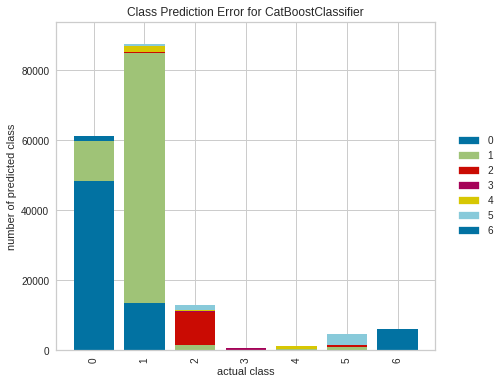

In [60]:
plot_model(custom_tuned_cb, plot='error')

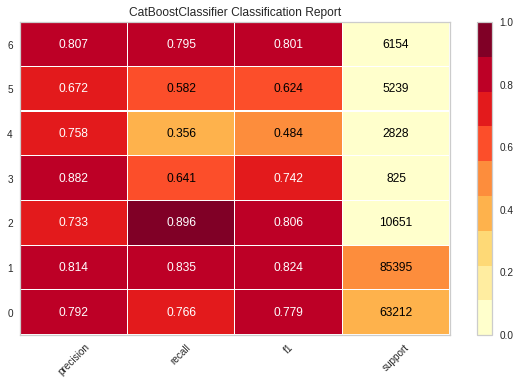

In [61]:
plot_model(custom_tuned_cb, plot='class_report')

# predit train and test data with tuned model
### make metric dataframes

In [62]:
grand_dataframe_creation(custom_tuned_cb, 'tuned cat boost', df_su, su_train_indices, su_test_indices)

In [63]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support
0,tuned cat boost,train,1,0.796778,0.769909,0.783113,148628
1,tuned cat boost,train,2,0.814212,0.836256,0.825087,197906
2,tuned cat boost,train,3,0.737574,0.896148,0.809165,25103
3,tuned cat boost,train,4,0.871849,0.647763,0.743284,1922
4,tuned cat boost,train,5,0.754295,0.349137,0.477333,6665
5,tuned cat boost,train,6,0.669116,0.578249,0.620372,12128
6,tuned cat boost,train,7,0.804521,0.803288,0.803904,14356
7,tuned cat boost,test,1,0.791983,0.766437,0.779001,63212
8,tuned cat boost,test,2,0.814191,0.834967,0.824448,85395
9,tuned cat boost,test,3,0.732571,0.895784,0.805998,10651


In [64]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
0,tuned cat boost,train,0.797975,0.778335,0.697250,0.723180,0.797732,0.797975,0.795827
1,tuned cat boost,test,0.796138,0.779587,0.695937,0.722987,0.796019,0.796138,0.794072


# finalize model
### fit with all data

In [65]:
finalized_cb = finalize_model(custom_tuned_cb)

### save finalized model

In [66]:
save_model(finalized_cb, 'finalized_cb_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                             'geologic_zone'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='cover_type', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='cover_type')),
                 ('fix_perfect', Remove_100(target='cover_type')),
                 ('clean_names', Clean_Colum_Names()),
                 (

In [67]:
saved_finalized_model_cb = load_model('finalized_cb_model')

Transformation Pipeline and Model Successfully Loaded


In [68]:
type(saved_finalized_model_cb)
saved_finalized_model_cb

sklearn.pipeline.Pipeline

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                            'geologic_zone'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='cover_type', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='cover_type')),
                ('fix_perfect', Remove_100(target='cover_type')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select',

In [69]:
pickle.dump(saved_finalized_model_cb,
            open(tuning_results_dir + 'finalized_cb_model.pkl', 'wb'),  protocol=4)

In [70]:
finalized_cb_model_loaded = pickle.load(open(tuning_results_dir + 'finalized_cb_model.pkl', 'rb'))

In [71]:
finalized_cb_model_loaded

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['wilderness_index',
                                                            'geologic_zone'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='cover_type', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='cover_type')),
                ('fix_perfect', Remove_100(target='cover_type')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select',

### investigate finalized model performance

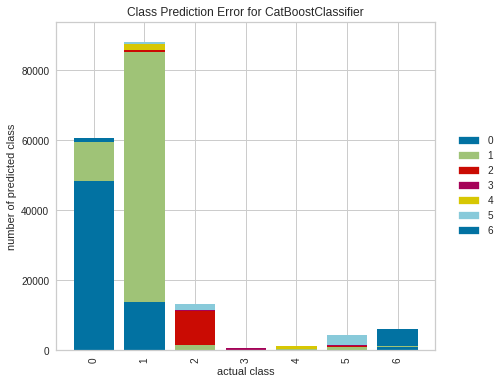

In [72]:
plot_model(finalized_cb, plot='error')

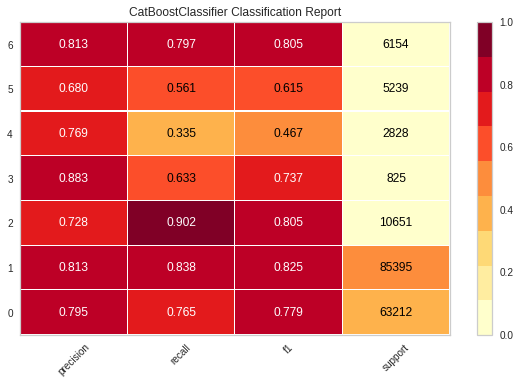

In [73]:
plot_model(finalized_cb, plot='class_report')

### predict all data

In [74]:
empty_list = []
grand_dataframe_creation(finalized_cb, 'finalized cat boost', df_su, empty_list, empty_list)

In [75]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support
0,tuned cat boost,train,1,0.796778,0.769909,0.783113,148628
1,tuned cat boost,train,2,0.814212,0.836256,0.825087,197906
2,tuned cat boost,train,3,0.737574,0.896148,0.809165,25103
3,tuned cat boost,train,4,0.871849,0.647763,0.743284,1922
4,tuned cat boost,train,5,0.754295,0.349137,0.477333,6665
5,tuned cat boost,train,6,0.669116,0.578249,0.620372,12128
6,tuned cat boost,train,7,0.804521,0.803288,0.803904,14356
7,tuned cat boost,test,1,0.791983,0.766437,0.779001,63212
8,tuned cat boost,test,2,0.814191,0.834967,0.824448,85395
9,tuned cat boost,test,3,0.732571,0.895784,0.805998,10651


In [76]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
0,tuned cat boost,train,0.797975,0.778335,0.697250,0.723180,0.797732,0.797975,0.795827
1,tuned cat boost,test,0.796138,0.779587,0.695937,0.722987,0.796019,0.796138,0.794072
2,finalized cat boost,all,0.795767,0.776152,0.686905,0.714585,0.795532,0.795767,0.793248


# pickle metric dataframes
### need `protocol=4` to read on local machine (default=5 when run on Paperspace)
https://docs.python.org/3/library/pickle.html

In [77]:
df_report_by_class.to_pickle(tuning_results_dir + 'tuned_cb_df_report_by_class.pkl', protocol=4)
df_report_summary.to_pickle(tuning_results_dir  + 'tuned_cb_df_report_summary.pkl',  protocol=4)